### Melanoma Detection Assignment
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Steps involved:
1. Data Reading/Data Understanding, Dataset Creation
2. Dataset visualisation
3. Model Building
  - 3.1 Initial Model Building
  - 3.2 Model Building with Augmented Data
  - 3.3 Handling class imbalances
  - 3.4 Model Building & training on the rectified class imbalance dataset

##### Importing all the important libraries

In [48]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from glob import glob
import glob
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [3]:
#Parameters
batch_size = 32
img_height = 180
img_width = 180
root_path = '/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration'

In [4]:
## Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Unzipping floder
!unzip /content/gdrive/MyDrive/CNN_Swathi/CNN_assignment.zip -d /content/gdrive/MyDrive/AI/CNN_Assignment

unzip:  cannot find or open /content/gdrive/MyDrive/AI/CNN_assignment.zip, /content/gdrive/MyDrive/AI/CNN_assignment.zip.zip or /content/gdrive/MyDrive/AI/CNN_assignment.zip.ZIP.


##### Utility API's

In [5]:
#API to return Model
#It takes drop_out, bath_norm as inputs
# to check, if dropouts, and batch normalization to be added in model
def get_model(drop_out,batch_norm):
  #In this case  we are using 3 Convollution layers (Conv2D+Maxpool2D), followed by Flatten (to convert to 1D), and Dense Layer
  model = Sequential()
  #Sequential allows you to create models layer-by-layer
  # Rescaling Images to Normal Pixel Value
  model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

  #First Convulation layer
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
  #Batch Normalization
  if batch_norm == True:
    model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))

  #Second Convulation Layer
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  #Batch Normalization
  if batch_norm == True:
    model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))


  #Third Convulation Layer
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
  #Batch Normalization
  if batch_norm == True:
    model.add(BatchNormalization())

  model.add(MaxPool2D(pool_size=(2,2)))

  #DropOut
  if drop_out == True:
    # Dropout at hidder layer with 40% Fraction of the input units to drop.
    model.add(Dropout(0.4))

  #Flatten Layer
  ##To flatten the multi-dimensional input tensors into a single dimension.
  model.add(Flatten())

  #Dense Layer
  model.add(Dense(128,activation='relu'))

  #DropOut
  if drop_out == True:
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(0.25))

  if batch_norm == True:
    model.add(BatchNormalization())

  #Dense Layer with softmax activation function.
  model.add(Dense(len(class_names),activation='softmax'))
  return model

In [6]:
#Utility API to plot the model
def plot_model(history,epochs):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [7]:
#Utility API for getting class distribution count
def get_class_distribution_count(dir_path):
    #count number of image in each classes
    sub_dir_file_count= []
    sub_dir_name = []
    for path in pathlib.Path(dir_path).iterdir():
        if path.is_dir():
            sub_dir_file_count.append(len([dir_name for dir_name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, dir_name))]))
    #Sub Directory Names
    sub_dir_name = [dir_name for dir_name in os.listdir(dir_path)
                    if os.path.isdir(os.path.join(dir_path, dir_name))]
    return sub_dir_name,sub_dir_file_count

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(root_path+'/Train')
data_dir_test = pathlib.Path(root_path+'/Test')

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
#list of classes present in Validation dataset 
print(val_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [13]:
#list of classes present in Training dataset 
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##### Visualize the data
###### Todo, create a code to visualize one instance of all the nine classes present in the dataset


/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027884.jpg
/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025691.jpg
/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0027044.jpg
/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000141.jpg
/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000028.jpg
/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024623.jpg
/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_001081

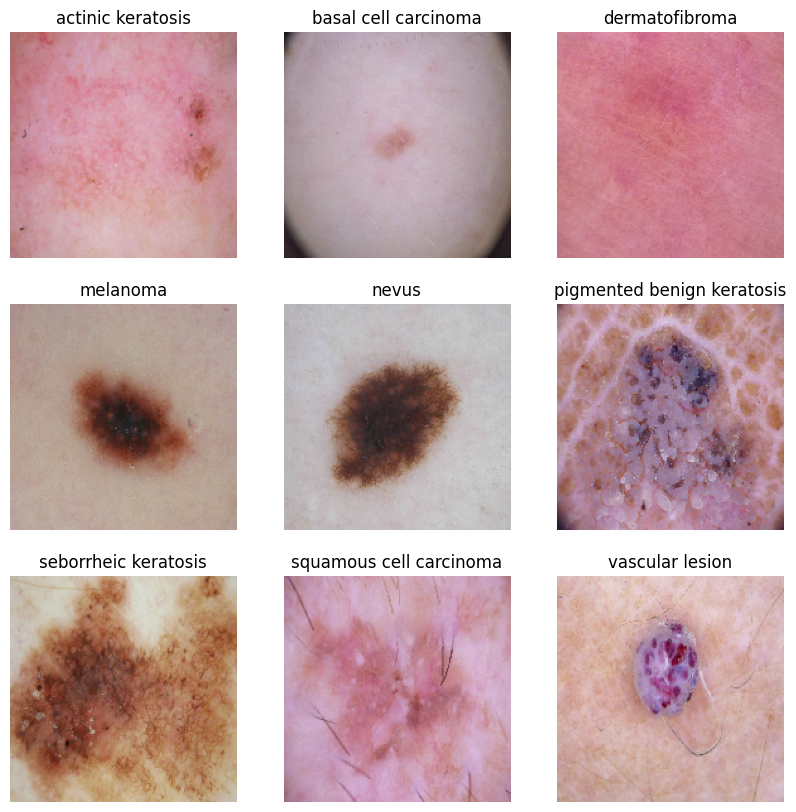

In [15]:
#Dictionary to store the path of image as per the class
class_file_path = {}

#Data Visualization
index = 0
plt.figure(figsize=(10,10))
for each_class in class_names:
  curr_path = str(data_dir_train)+'/'+each_class+'/'
  class_file_path[each_class] = curr_path + os.listdir(curr_path)[0]
  print(class_file_path[each_class])
  index += 1
  plt.subplot(3,3,index)
  plt.imshow(load_img(class_file_path[each_class],target_size=(180,180)))
  plt.title(each_class)
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

##### Model - 1 Without Dropouts and batch normalization

In [17]:
#Model without any dropout and batch normalization
#First parameter False means dropout is not selected
#Second parameter False means batch normalization is not selected
model1 = get_model(False,False)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [20]:
epochs = 20
history1 = model1.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 171s 3s/step - loss: 2.0791 - accuracy: 0.2126 - val_loss: 1.8530 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7262 - accuracy: 0.3650 - val_loss: 1.6000 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5599 - accuracy: 0.4526 - val_loss: 1.4519 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.4231 - accuracy: 0.5017 - val_loss: 1.4632 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 2s 33ms/step - loss: 1.3660 - accuracy: 0.5223 - val_loss: 1.4174 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.2536 - accuracy: 0.5379 - val_loss: 1.3772 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1806 - accuracy: 0.5882 - val_loss: 1.4514 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

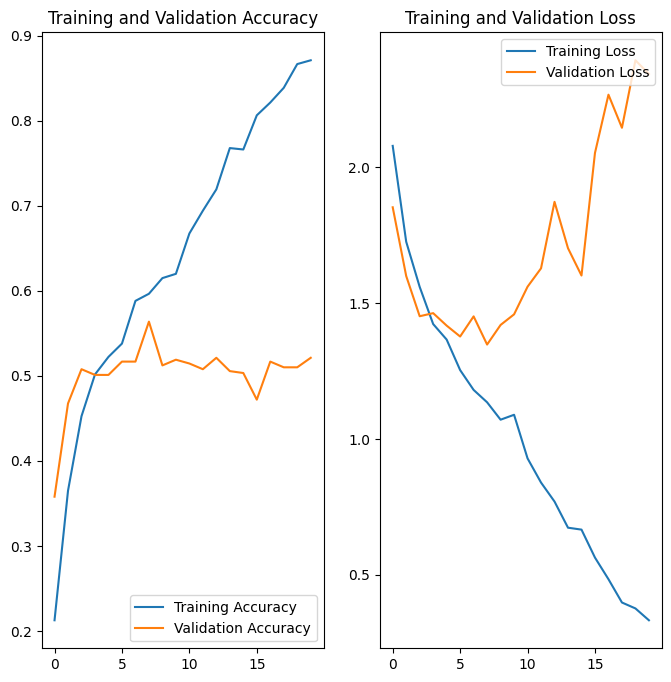

In [21]:
#Plot the model
plot_model(history1,20)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##### **Observations:** Model 1
- Training Accuracy (`87.1%`), Test Accuracy (`52.1%`)
- Training Loss (`0.33`), Validation Loss (`2.34`)
- Training accuracy keep increasing, but Test accuracy is not increasing after initial loops, and there is huge gap between train and test accuracy. **`So the model is over fitting.`**





##### Model 2 - With Dropouts and without Batch normalization

In [22]:
#Model without any dropout and batch normalization
#First parameter False means dropout is selected
#Second parameter False means batch normalization is not selected
model2 = get_model(True,False)

In [23]:
### Todo, choose an appropirate optimiser and loss function
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

In [25]:
epochs = 20
history2 = model2.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
  )

Epoch 1/20
56/56 [==============================] - 8s 58ms/step - loss: 2.0227 - accuracy: 0.2439 - val_loss: 1.7547 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6713 - accuracy: 0.4040 - val_loss: 1.6987 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5379 - accuracy: 0.4682 - val_loss: 1.7050 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4404 - accuracy: 0.4933 - val_loss: 1.3991 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3730 - accuracy: 0.5212 - val_loss: 1.4705 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3686 - accuracy: 0.5061 - val_loss: 1.5213 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.2961 - accuracy: 0.5485 - val_loss: 1.3882 - val_accuracy: 0.5459
Epoch 8/20
56

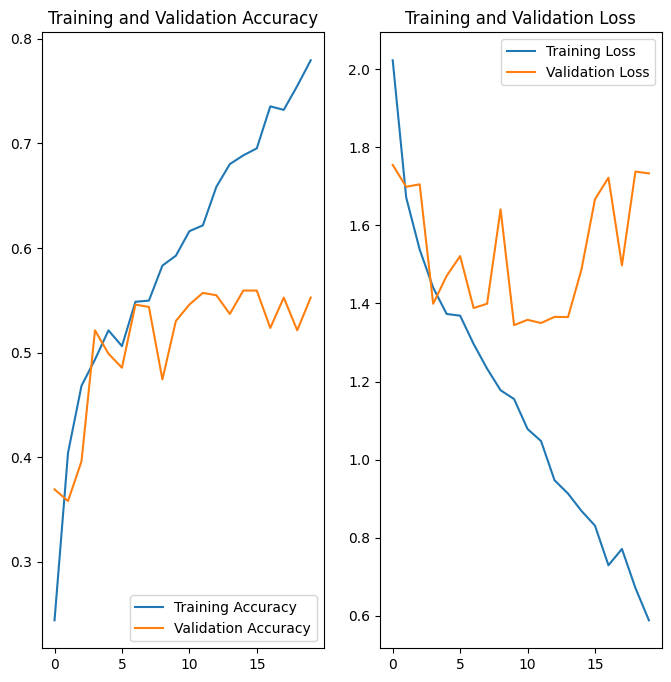

In [26]:
#Plot the model
plot_model(history2,20)

##### **Observations:** Model 2
- Training Accuracy (`77.9%`), Test Accuracy (`55.2%`)
- Training Loss (`0.58`), Validation Loss (`1.73`)
- Training accuracy also went down this time when compared model 1, There is huge gap between train and test accuracy this shows **`the model is overfitting`**`



##### Model 3 - With both Dropouts and Batch Normalization to reduce overfitting

In [27]:
#Model without any dropout and batch normalization
#First parameter False means dropout is selected
#Second parameter False means batch normalization is not selected
model3 = get_model(True,True)

In [28]:
### Todo, choose an appropirate optimiser and loss function
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 87, 87, 64)       

In [30]:
epochs = 20
history3 = model3.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 85ms/step - loss: 1.8586 - accuracy: 0.4118 - val_loss: 2.2739 - val_accuracy: 0.1655
Epoch 2/20
56/56 [==============================] - 5s 83ms/step - loss: 1.4392 - accuracy: 0.5078 - val_loss: 2.6198 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.2923 - accuracy: 0.5379 - val_loss: 2.7046 - val_accuracy: 0.1544
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.1175 - accuracy: 0.6099 - val_loss: 2.7418 - val_accuracy: 0.1700
Epoch 5/20
56/56 [==============================] - 5s 81ms/step - loss: 1.0050 - accuracy: 0.6490 - val_loss: 2.4356 - val_accuracy: 0.2908
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 0.9173 - accuracy: 0.6674 - val_loss: 2.5642 - val_accuracy: 0.1902
Epoch 7/20
56/56 [==============================] - 5s 83ms/step - loss: 0.7826 - accuracy: 0.7215 - val_loss: 2.7161 - val_accuracy: 0.2975
Epoch 8/20
56

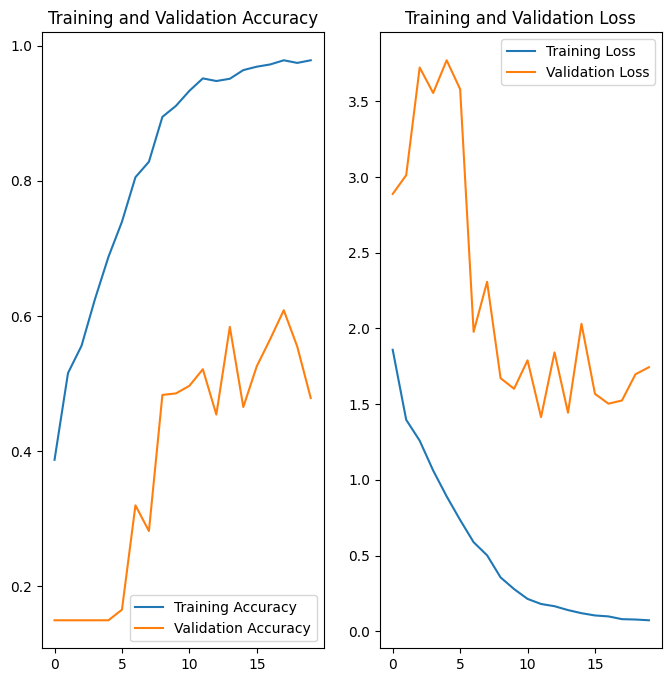

In [ ]:
#Plot the model
plot_model(history3,20)

##### **Observations**: Model 3

- Training Accuracy (`96.6%`), Validation Accuracy (`54.3%`). The difference shows model is clearly ovverfitting.
- Training Loss (`0.09`), Validation Loss (`1.85`).
- So  **`batch normalization and dropouts are not helping,  it is leading to overfitting`**.
# New Section

##### Model 4 - Data augumentation strategy.

In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
#Define data_augmentation
data_augmentation = keras.Sequential([
      layers.experimental.preprocessing.RandomFlip(mode="horizontal",input_shape=(img_height,img_width,3)),
      layers.experimental.preprocessing.RandomRotation(0.1),
      layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
      layers.experimental.preprocessing.RandomCrop(180, 180),
      layers.experimental.preprocessing.RandomContrast(factor=0.2)


])

In [33]:
  model4 = Sequential(
      [
          data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))
      ]
  )
  #First Convolution layer
  model4.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
  model4.add(MaxPool2D(pool_size=(2,2)))

  #Second Convolution Layer
  model4.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  model4.add(MaxPool2D(pool_size=(2,2)))

  #Third Convolution Layer
  model4.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
  model4.add(MaxPool2D(pool_size=(2,2)))

  #DropOut  layer with 40% Fraction of the input units to drop.
  model4.add(Dropout(0.4))

  #Flatten Layer
  ##To flatten the multi-dimensional input tensors into a single dimension.
  model4.add(Flatten())

  #Dense Layer
  model4.add(Dense(128,activation='relu'))

  #DropOut
  #Dropout layer with 25% Fraction of the input units to drop.
  model4.add(Dropout(0.25))

  #Dense Layer with softmax activation function.
  model4.add(Dense(len(class_names),activation='softmax'))

In [36]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                

In [37]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
epochs = 20
history4 = model4.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 63ms/step - loss: 2.0024 - accuracy: 0.2433 - val_loss: 1.8513 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 1.7675 - accuracy: 0.3850 - val_loss: 1.5282 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.5699 - accuracy: 0.4448 - val_loss: 1.5106 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 3s 59ms/step - loss: 1.5558 - accuracy: 0.4381 - val_loss: 1.6487 - val_accuracy: 0.3960
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4696 - accuracy: 0.4872 - val_loss: 1.4451 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 3s 59ms/step - loss: 1.3913 - accuracy: 0.4978 - val_loss: 1.3826 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 3s 60ms/step - loss: 1.3889 - accuracy: 0.5123 - val_loss: 1.3698 - val_accuracy: 0.5190
Epoch 8/20
56

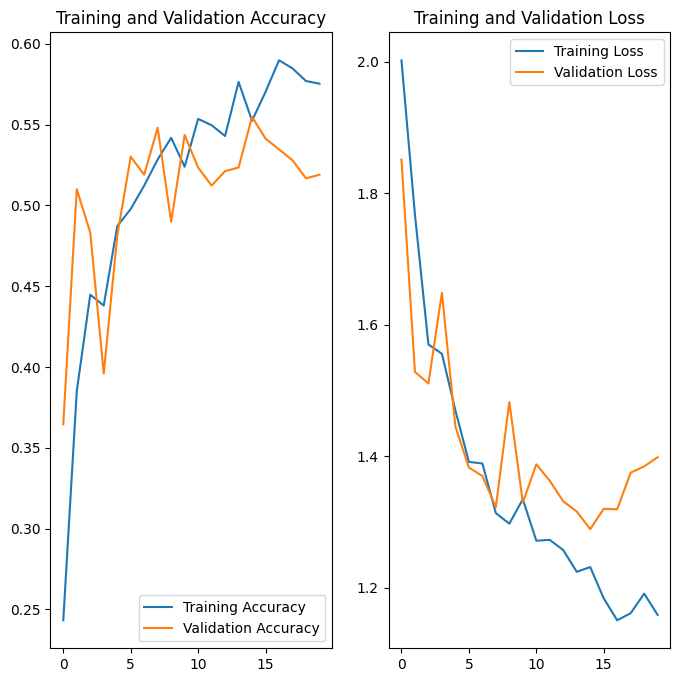

In [39]:
#Plot the model
plot_model(history4,20)

##### **Observations**: Model 4

- With Augmentation the model the training accuracy (`57.5%`) is also reduced. Though the difference between training and validation accuracy (`51.9%`) is reduced, it looks the model is `underfitting`.
- Moreover, even the loss also increased in this case for training (`1.15`), as well as validation(`1.39`)


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [40]:
# Get directory names, and file count in each directory.
dir_names,file_count = get_class_distribution_count(data_dir_train)
class_dist_df = pd.DataFrame(list(zip(dir_names,file_count)),columns =['ClassName', 'Image Count'])
class_dist_df

,ClassName,Image Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='Image Count', ylabel='ClassName'>

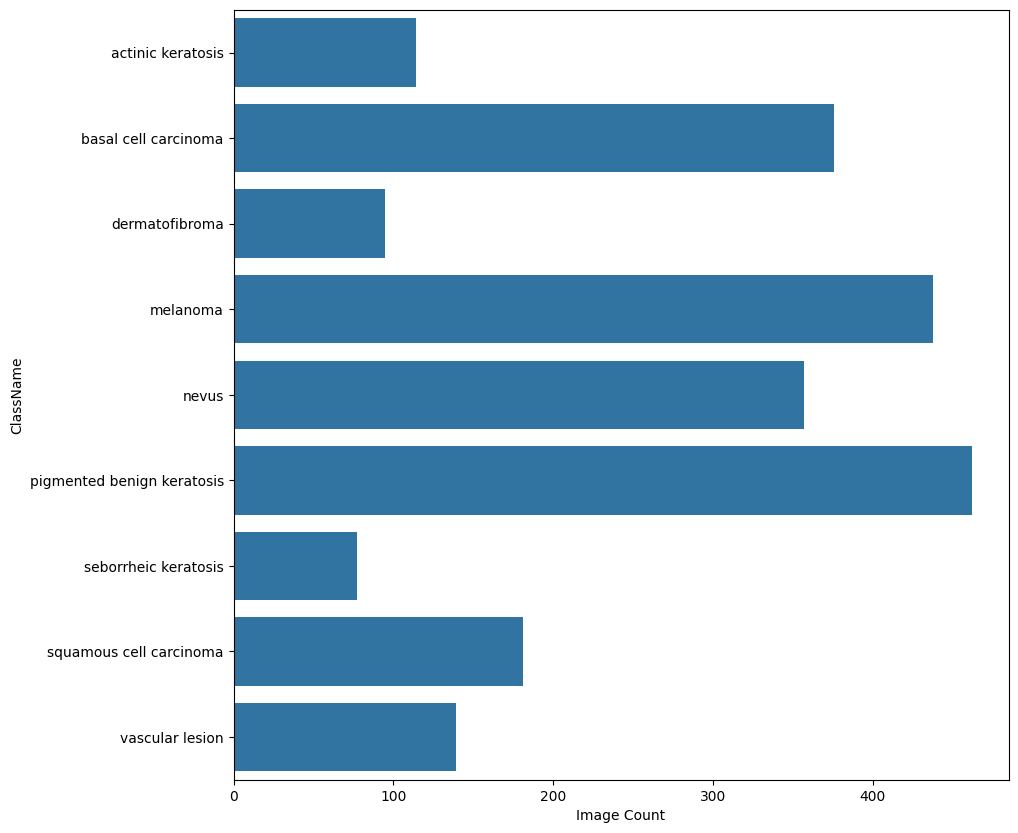

In [41]:
#Visualization of the class distribution
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="Image Count", y="ClassName", data=class_dist_df)

#### **Todo:** Write your findings here:
- As per the above count, it clearly indicates there is **class imbalance**, as the data is skewed, and there are more images of the class `pigmented benign keratosis` and `Melanoma` (>400), and relatively fewer images of `seborrheic keratosis ` and `dermatofibroma` (<100)

#### - Which class has the least number of samples?

- `seborrheic keratosis ` and `dermatofibroma`(<100)

#### - Which classes dominate the data in terms proportionate number of samples?
- `pigmented benign keratosis` and `Melanoma` (>400) dominate the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
#To remove output directory, is alreay present
# This is to ensure the directory is removed on multiple rerun
output_dir_prefix  = "/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
  output_dir = output_dir_prefix+i+"/output/"
  try:
      shutil.rmtree(output_dir)
      print("Removed",output_dir)
  except OSError as e:
      print("Error: %s - %s." % (e.filename, e.strerror))

Error: /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/ - No such file or directory.
Error: /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/ - No such file or directory.
Error: /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/ - No such file or directory.
Error: /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/ - No such file or directory.
Error: /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/ - No such file or directory.
Error: /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/ - No such

In [44]:
#output_dir_prefix =      "/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
path_to_training_dataset='/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABA943937C0>: 100%|██████████| 500/500 [00:21<00:00, 23.58 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABA94337CA0>: 100%|██████████| 500/500 [00:18<00:00, 27.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABA944591B0>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7ABBC23CF850>: 100%|██████████| 500/500 [01:16<00:00,  6.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7ABA942491B0>: 100%|██████████| 500/500 [01:22<00:00,  6.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABA953D0670>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7ABA944598D0>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABB0060B2B0>: 100%|██████████| 500/500 [00:17<00:00, 27.96 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABA9425F910>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [45]:
from glob import glob
print(path_to_training_dataset)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

/content/gdrive/MyDrive/AI/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
4500


- For each class 500 images gets added. So total images added are 4500.

In [49]:
#Original Path list
path_list_orig = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [50]:
original_dict = dict(zip(path_list_orig, lesion_list_orig))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
1,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
2,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
3,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
4,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
...,...,...
2234,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
2235,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
2236,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
2237,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train


In [51]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [52]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [53]:
#Create a Data Frame of Path, Labels for newly added images
dataframe_dict_new = dict(zip(path_list, lesion_list))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,actinic keratosis
1,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,actinic keratosis
2,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,actinic keratosis
3,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,actinic keratosis
4,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion
4496,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion
4497,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion
4498,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
#Append Original df
new_df = pd.concat([original_df, df2], axis=0)
new_df

,Path,Label
0,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
1,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
2,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
3,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
4,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,Train
...,...,...
4495,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion
4496,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion
4497,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion
4498,/content/gdrive/MyDrive/AI/CNN_Assignment/Skin...,vascular lesion


In [55]:
new_df['Label'].value_counts()

Label
Train                         2239
actinic keratosis              500
basal cell carcinoma           500
dermatofibroma                 500
melanoma                       500
nevus                          500
pigmented benign keratosis     500
seborrheic keratosis           500
squamous cell carcinoma        500
vascular lesion                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

2239 existing images + 4500 newly added images with help of Augmentor library. Total images 6739

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [56]:
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [57]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [58]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [59]:
## your code goes here
#Model with dropouts and without BN
model5 = get_model(True,False)

In [60]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

In [61]:
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
#Model Fit
history5 = model5.fit(train_ds_aug, validation_data=val_ds_aug, epochs=30)

Epoch 1/30
169/169 [==============================] - 52s 120ms/step - loss: 1.9393 - accuracy: 0.2578 - val_loss: 1.6109 - val_accuracy: 0.4098
Epoch 2/30
169/169 [==============================] - 9s 55ms/step - loss: 1.5631 - accuracy: 0.4125 - val_loss: 1.3758 - val_accuracy: 0.5167
Epoch 3/30
169/169 [==============================] - 9s 56ms/step - loss: 1.3441 - accuracy: 0.4918 - val_loss: 1.2340 - val_accuracy: 0.5575
Epoch 4/30
169/169 [==============================] - 9s 56ms/step - loss: 1.2233 - accuracy: 0.5456 - val_loss: 1.1874 - val_accuracy: 0.5382
Epoch 5/30
169/169 [==============================] - 9s 56ms/step - loss: 1.0985 - accuracy: 0.5940 - val_loss: 1.1313 - val_accuracy: 0.5850
Epoch 6/30
169/169 [==============================] - 9s 55ms/step - loss: 0.9738 - accuracy: 0.6422 - val_loss: 0.9714 - val_accuracy: 0.6659
Epoch 7/30
169/169 [==============================] - 9s 55ms/step - loss: 0.8936 - accuracy: 0.6725 - val_loss: 0.9247 - val_accuracy: 0.66

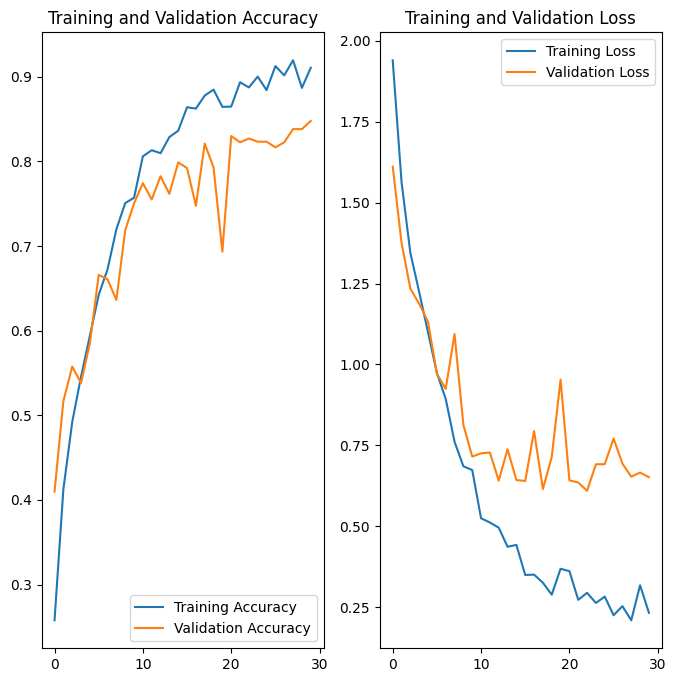

In [63]:
plot_model(history5,30)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



##### Observations: Final model
- Train accuracy (91.0%), validation accuracy (84.7%) after 30 loops. Seeing the trend, the gap can probably be further reduced, if the number of epochs are more.

- With Augmentor library, Train and validation accuracy are close, so the overfitting problem is also addressed and the gap between train and test set is hugely reduced.

- Even the Loss for training (0.23), and test (0.65) where the difference in the Loss also reduced as compared earlier models.


